# Titanic - Machine Learning from Disaster
### Goal:
- Predict if passengers survied the sinking of the Titanic or not
## Contents:
* [EDA](#EDA)
* [Preprocessing](#Preprocessing)
    * [Form ML Pipelines](#Form-ML-Pipelines)
* [Testing](#Testing)
    * [Parameter Tuning](#Parameter-Tuning)
    * [Final Model Testing](#Final-Model-Testing)
* [Testing Results](#Testing-Results)
    * [Prepping Test Results](#Prepping-Test-Results)

In [74]:
import pandas as pd
import numpy as np

In [75]:
df = pd.read_csv('train.csv')
sample = pd.read_csv('gender_submission.csv')

In [76]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [77]:
# Check amount of NaN values in dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [78]:
# Check feature cardinality
df.nunique(dropna=True)

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

## EDA

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot size
plt.rcParams['figure.figsize'] = [15, 6]

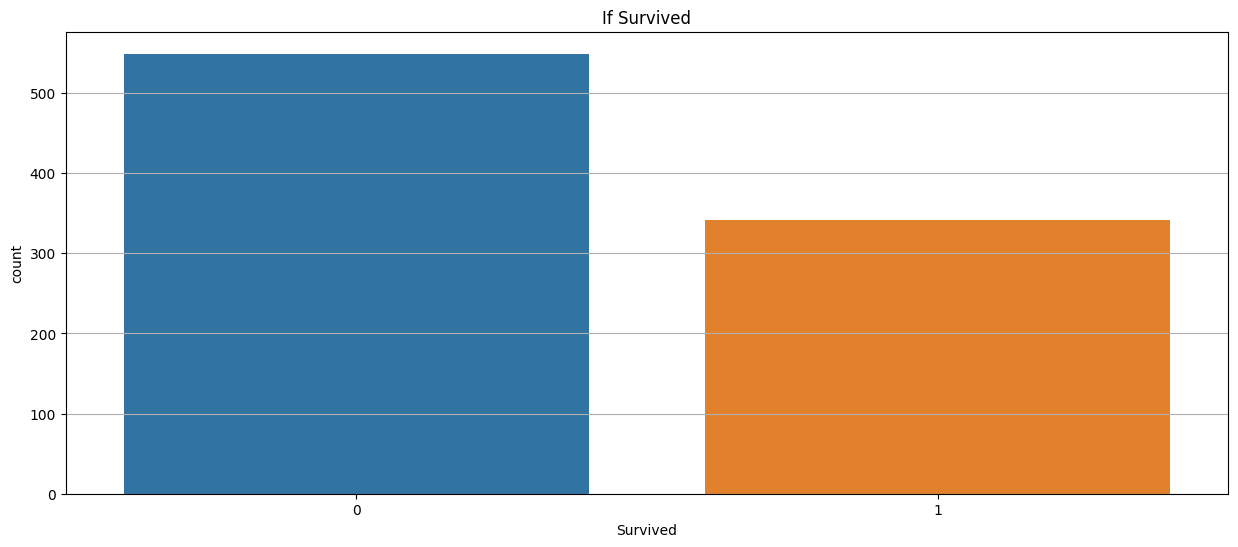

In [80]:
# Check target label imbalance
plt.title('If Survived')
plt.grid(True)
sns.countplot(x=df['Survived'], data=df)
plt.show()

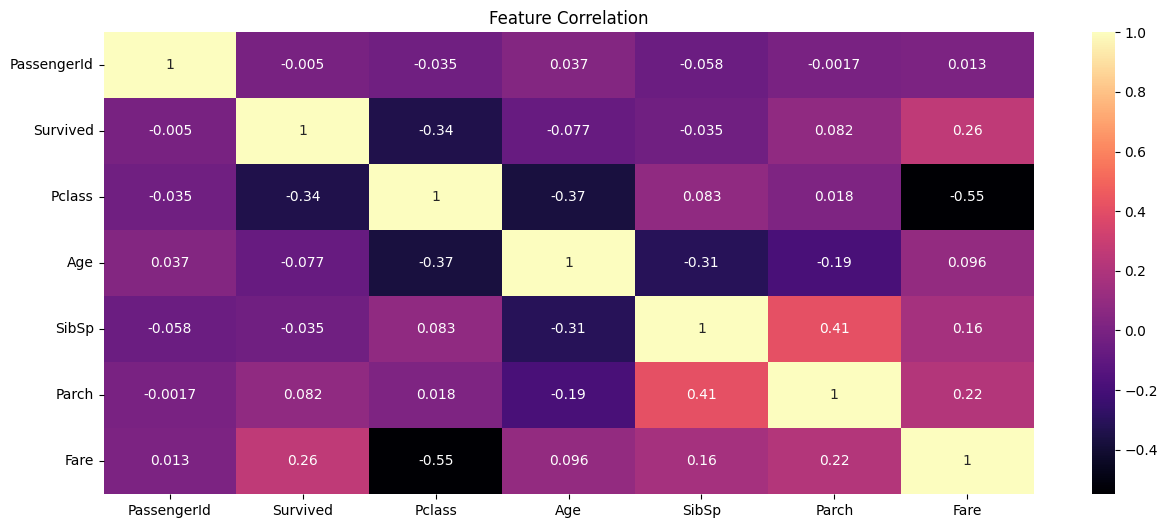

In [81]:
# Check for correlations between each feature
plt.title('Feature Correlation')
sns.heatmap(df.corr(), annot=True, cmap='magma')
plt.show()

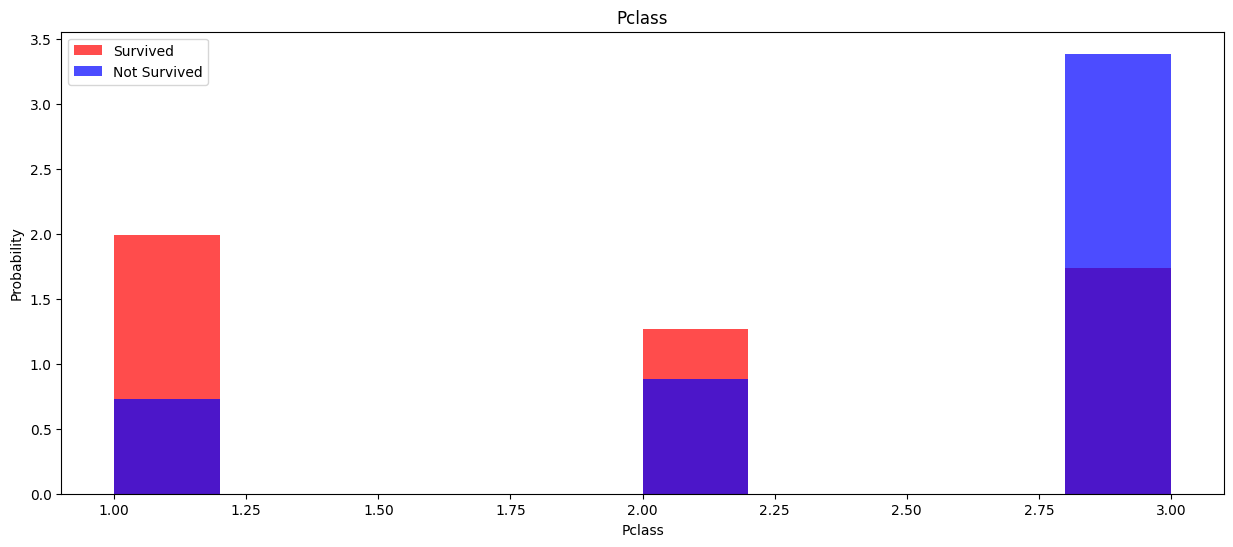

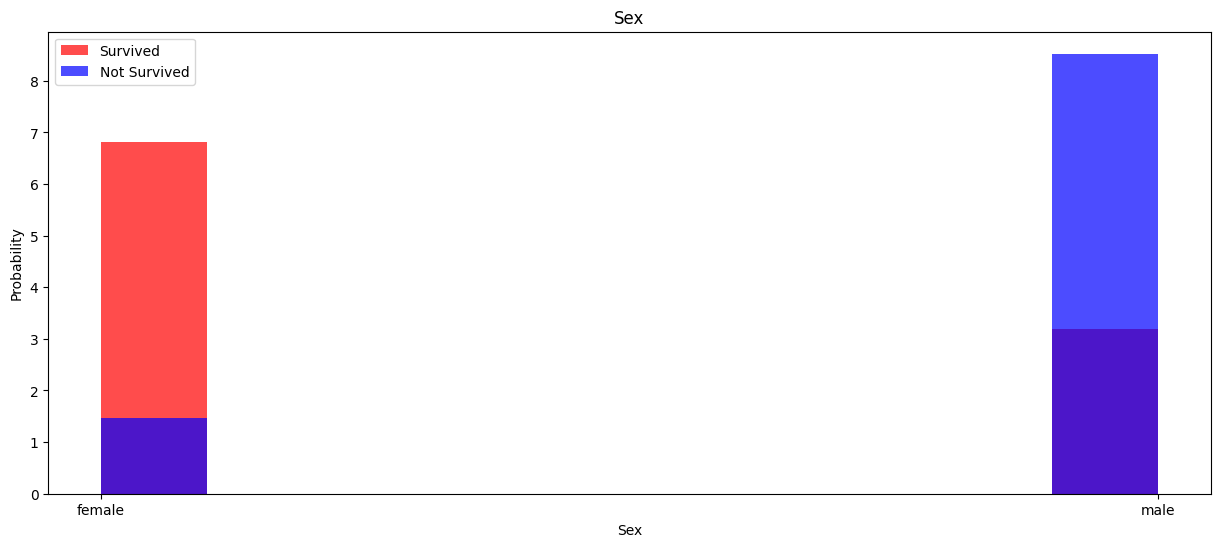

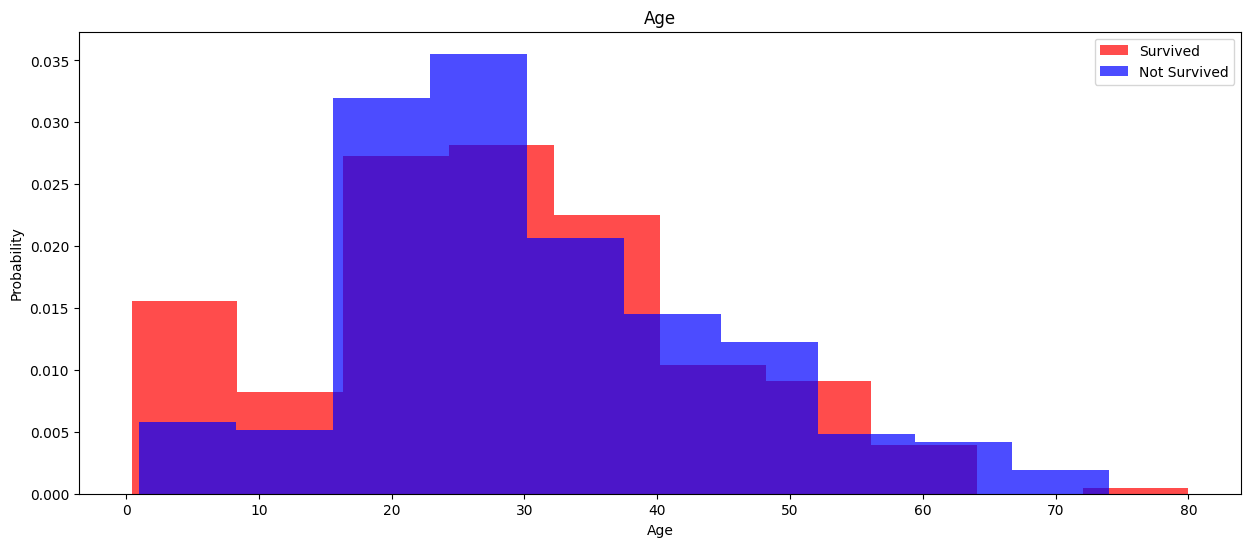

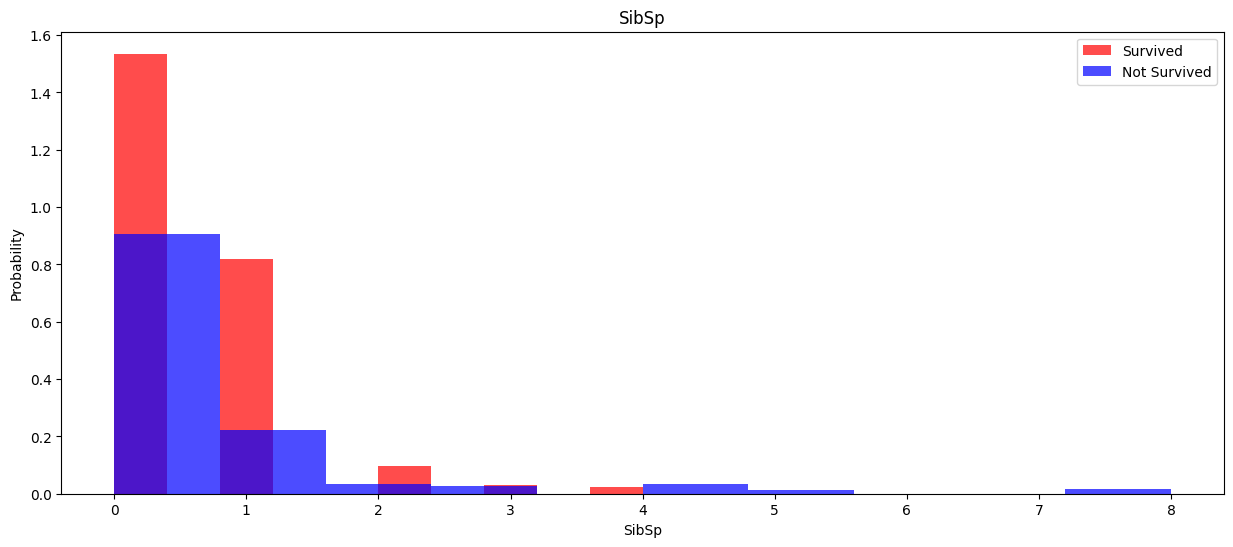

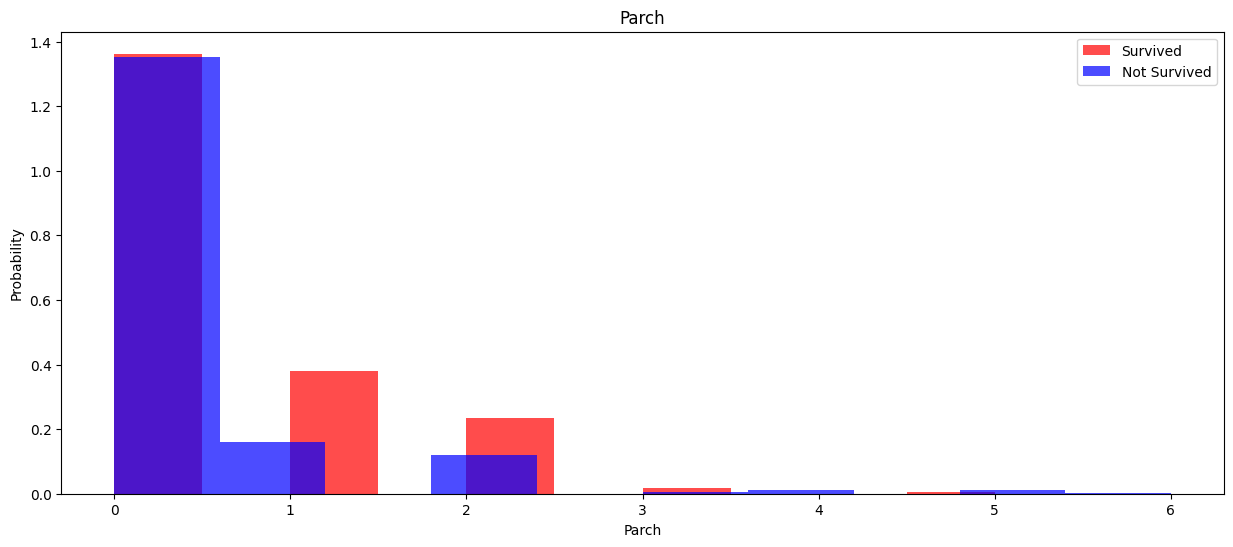

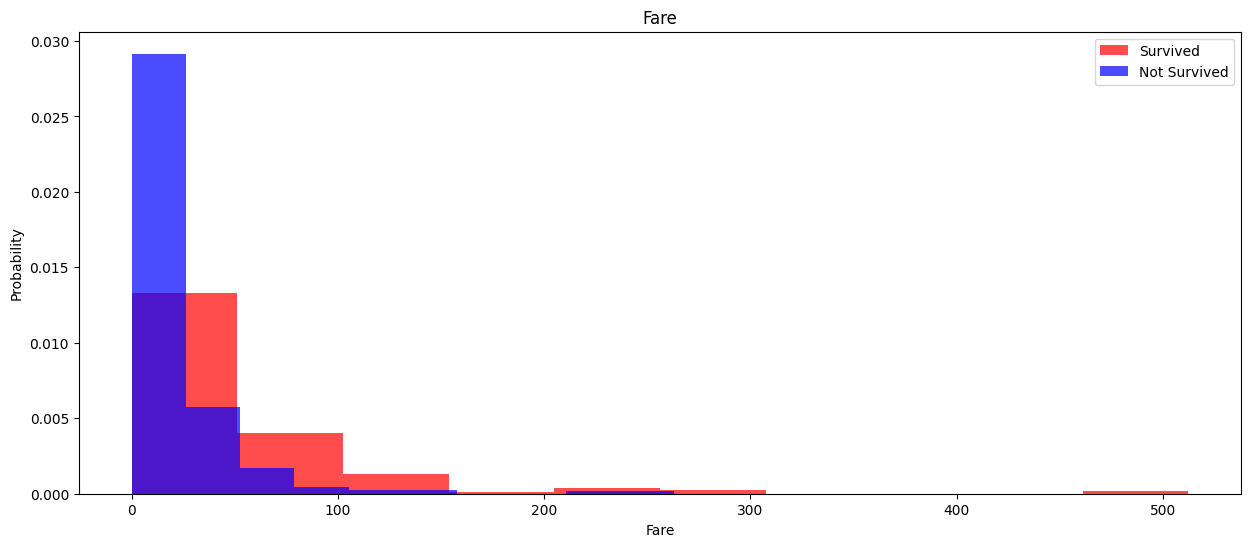

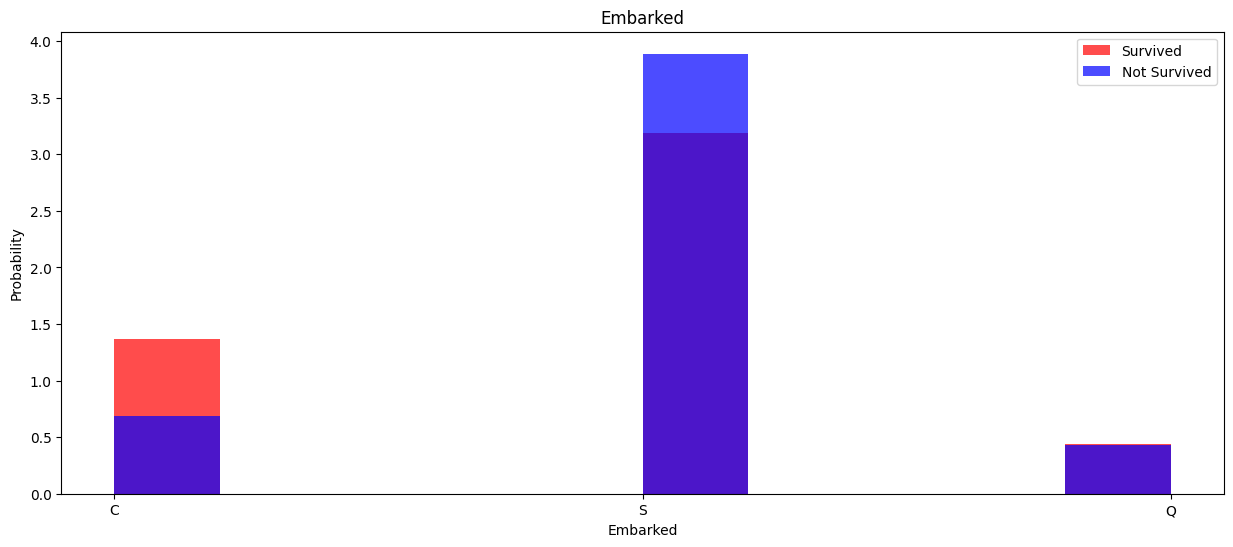

In [82]:
# Plot histograms to compare target label with key features
key_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
s = df[df['Survived'] == 1]
ns = df[df['Survived'] == 0]

for feature in key_features:
    plt.title(feature)
    plt.hist(s[feature].dropna(), label='Survived', density=True, alpha=0.7, color='red')
    plt.hist(ns[feature].dropna(), label='Not Survived', density=True, alpha=0.7, color='blue')
    plt.ylabel('Probability')
    plt.xlabel(feature)
    plt.legend()
    plt.show()

## Preprocessing

In [83]:
from imblearn.over_sampling import RandomOverSampler

In [84]:
def clean_columns(X):
    # Drop columns with high cardinality
    X.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)
    X['Embarked'].fillna('Unknown', inplace=True)
    

def over_sample(X, y):
    # Runs over-sampling on training set
    ros = RandomOverSampler(random_state=1234)
    X_new, y_new = ros.fit_resample(X, y)
    return X_new, y_new 

--

In [85]:
from sklearn.model_selection import train_test_split

In [86]:
X, y = df.drop(['Survived'], axis=1), df['Survived']

In [87]:
# Split X, y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1234)

# Print shape of each set
print(f"Shape of x_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}\n")

# Run preporcessing on X_train, X_test
clean_columns(X_train)
clean_columns(X_test)

# Check values in y_train
print(f"Resample training data...\n")
print(f"Before Resampling:")
print(f"{y_train.value_counts()}\n")

# Resample 
X_train, y_train = over_sample(X_train, y_train)

# Re-check value counts in y_train
print(f"After Resampling:")
print(f"{y_train.value_counts()}\n")

# New X_train/y_train shape
print(f"New shape of X_train: {X_train.shape}")
print(f"New shape of y_train: {y_train.shape}")

Shape of x_train: (623, 11)
Shape of y_train: (623,)
Shape of X_test: (268, 11)
Shape of y_test: (268,)

Resample training data...

Before Resampling:
0    383
1    240
Name: Survived, dtype: int64

After Resampling:
1    383
0    383
Name: Survived, dtype: int64

New shape of X_train: (766, 7)
New shape of y_train: (766,)


--
#### Form ML Pipelines

In [88]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [89]:
# Separate categorical/numerical features
categorical_features = X_train.select_dtypes(include='object').columns
numerical_features = X_train.select_dtypes(include=np.number).columns

# Numeric pipeline
numeric_pre = Pipeline([
    ('Imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('Scaler', MinMaxScaler())
])

# Categorical pipeline
cat_pre = Pipeline([
    ('OneHot', OneHotEncoder())
])

# Transform categorical/numerical features
column_trans = make_column_transformer(
    (cat_pre, categorical_features),
    (numeric_pre, numerical_features),
    remainder='passthrough'
)

In [90]:
xgb_clf = XGBClassifier()
rf_clf = RandomForestClassifier()
lr_clf = LogisticRegression()

In [91]:
# Final ML pipelines
xgb_pipeline = Pipeline([('Col_Transformer', column_trans), ('XGB', xgb_clf)])
rf_pipeline = Pipeline([('Col_Transformer', column_trans), ('RandomForest', rf_clf)])
lr_pipeline = Pipeline([('Col_Transformer', column_trans), ('LogisticReg', lr_clf)])

ml_pipelines = {
    'XGB': xgb_pipeline, 
    'RandomForest': rf_pipeline, 
    'LogisticReg': lr_pipeline
}

## Testing 

In [92]:
from sklearn.metrics import (classification_report, mean_squared_error, confusion_matrix, f1_score, log_loss,
precision_score, recall_score, roc_curve, auc, accuracy_score)

In [93]:
def metric_testing(model, y_true, y_hat, test, title):
    y_probas = model.predict_proba(test)
    y_hat_loss = log_loss(y_true, y_probas)
    
    print(f"{title} EVALUATION -----------------")
    print(f"Log Loss Pred: {y_hat_loss}")
    print(f"Precision on X_test: {precision_score(y_true, y_hat)}")
    print(f"Recall on X_test: {recall_score(y_true, y_hat)}")
    print(f"Accuracy Score: {accuracy_score(y_true, y_hat)}")
    print(f"NULL ACCURACY SCORE ON Y_TEST: {max(y_true.mean(), 1 - y_true.mean())}\n")

In [94]:
# Run baseline evaluations for each model
for algo, pipeline in ml_pipelines.items():
    title, model = algo, pipeline[algo]
    pipeline.fit(X_train, y_train)
    y_predict = pipeline.predict(X_test)
    metric_testing(model, y_test, y_predict, pipeline['Col_Transformer'].transform(X_test), title)

XGB EVALUATION -----------------
Log Loss Pred: 0.6273216322417702
Precision on X_test: 0.7474747474747475
Recall on X_test: 0.7254901960784313
Accuracy Score: 0.8022388059701493
NULL ACCURACY SCORE ON Y_TEST: 0.6194029850746269

RandomForest EVALUATION -----------------
Log Loss Pred: 1.20445875579401
Precision on X_test: 0.76
Recall on X_test: 0.7450980392156863
Accuracy Score: 0.8134328358208955
NULL ACCURACY SCORE ON Y_TEST: 0.6194029850746269

LogisticReg EVALUATION -----------------
Log Loss Pred: 0.44778255348824125
Precision on X_test: 0.7572815533980582
Recall on X_test: 0.7647058823529411
Accuracy Score: 0.8171641791044776
NULL ACCURACY SCORE ON Y_TEST: 0.6194029850746269



#### Parameter Tuning

In [95]:
algo_params = {
    # XBG parameters
    'XGB': {
        'XGB__learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
        'XGB__max_depth': np.arange(1, 16),
        'XGB__min_child_weight': [1, 3, 5, 7, 9],
        'XGB__gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
        'XGB__colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7]
    },

    # RandomForest parameters
    'RandomForest': {
        'RandomForest__bootstrap': [True, False],
        'RandomForest__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'RandomForest__max_features': ['auto', 'sqrt'],
        'RandomForest__min_samples_leaf': [1, 2, 4],
        'RandomForest__min_samples_split': [2, 5, 10],
        'RandomForest__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
    },

    # LogisticReg parameters 
    'LogisticReg': {
        'LogisticReg__C': np.logspace(-9, 9, 20),
        'LogisticReg__penalty': ['l2'],
        'LogisticReg__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        'LogisticReg__max_iter': [10000]
    }
}

In [96]:
import warnings
import os

# Removes warnings in current job (RandomizedSearch CV)
warnings.filterwarnings("ignore")
# Removes warnings in spawned jobs
os.environ['PYTHONWARNINGS']='ignore'

from sklearn.model_selection import RandomizedSearchCV

In [97]:
fit_models = {}

# Loop though each pipeline while running RandomizedSearch
for algo, pipeline in ml_pipelines.items():
    print(f"Fitting {algo}...")
    try:
        random_grid = RandomizedSearchCV(
            pipeline, 
            param_distributions=algo_params[algo], 
            n_iter=300, 
            scoring='f1', 
            n_jobs=-1, 
            cv=5, 
            verbose=True
        )
        
        random_grid.fit(X_train, y_train)
    except Exception as e:
        continue
    
    # Add best params/estimator to fit_models
    fit_models[algo] = {
        'params': random_grid.best_params_,
        'estimator': random_grid.best_estimator_
    }

Fitting XGB...
Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Fitting RandomForest...
Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Fitting LogisticReg...
Fitting 5 folds for each of 120 candidates, totalling 600 fits


#### Final Model Testing

In [98]:
# Run metrics on final models
for algo, pipeline in ml_pipelines.items():
    try:
        best_model = fit_models[algo]['estimator']
        best_model.fit(X_train, y_train)
        y_predict = best_model.predict(X_test)
        metric_testing(best_model, y_test, y_predict, X_test, algo)
    except Exception as e:
        pass

XGB EVALUATION -----------------
Log Loss Pred: 0.439708639294574
Precision on X_test: 0.7321428571428571
Recall on X_test: 0.803921568627451
Accuracy Score: 0.8134328358208955
NULL ACCURACY SCORE ON Y_TEST: 0.6194029850746269

RandomForest EVALUATION -----------------
Log Loss Pred: 0.4383983814808885
Precision on X_test: 0.7777777777777778
Recall on X_test: 0.7549019607843137
Accuracy Score: 0.8246268656716418
NULL ACCURACY SCORE ON Y_TEST: 0.6194029850746269

LogisticReg EVALUATION -----------------
Log Loss Pred: 0.6931471387977425
Precision on X_test: 0.7931034482758621
Recall on X_test: 0.6764705882352942
Accuracy Score: 0.8097014925373134
NULL ACCURACY SCORE ON Y_TEST: 0.6194029850746269



Best params from previous testing:
- **0.832089552238806 (accuracy)**: {'RandomForest__n_estimators': 1800,
 'RandomForest__min_samples_split': 10,
 'RandomForest__min_samples_leaf': 4,
 'RandomForest__max_features': 'auto',
 'RandomForest__max_depth': 20,
 'RandomForest__bootstrap': True}
 
- **0.8432835820895522 (f1)**: {'RandomForest__n_estimators': 1800,
 'RandomForest__min_samples_split': 10,
 'RandomForest__min_samples_leaf': 1,
 'RandomForest__max_features': 'sqrt',
 'RandomForest__max_depth': 10,
 'RandomForest__bootstrap': True}
 
- **0.832089552238806 (roc_auc)**: {'XGB__min_child_weight': 1,
 'XGB__max_depth': 2,
 'XGB__learning_rate': 0.2,
 'XGB__gamma': 0.5,
 'XGB__colsample_bytree': 0.3}

## Testing Results

In [99]:
import pickle

In [100]:
def save_model(model):
    with open('model.pkl', 'wb') as f:
        pickle.dump(model, f)

def load_model(file):
    with open(file, 'rb') as f:
        return pickle.load(f)

In [101]:
# instantiating final model
final_model = RandomForestClassifier(
    n_estimators=1800, min_samples_split=10,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=10,
    bootstrap=True
)

final_pipeline = Pipeline([('Col_Transformer', column_trans), ('RandomForest', final_model)])

# Saving final model
save_model(final_pipeline)

In [105]:
# Load final model pipeline
clf = load_model('model.pkl')

# Load test data
test_df = pd.read_csv('test.csv')

# Load sample submission
sample_sub = pd.read_csv('gender_submission.csv')

In [106]:
# Preprocessing
X_train_final, y_train_final = df.drop(['Survived'], axis=1), df['Survived']
clean_columns(X_train_final)
X_train_final, y_train_final = over_sample(X_train_final, y_train_final)

# Fit training set on model
clf.fit(X_train_final, y_train_final)

Pipeline(steps=[('Col_Transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('OneHot',
                                                                   OneHotEncoder())]),
                                                  Index(['Sex', 'Embarked'], dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer()),
                                                                  ('Scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object'))])),
                ('RandomForest',
                 RandomForestClassifier(max_depth=10, min_samples_split=10,
                                        n_estimators=1800))])

#### Prepping Test Results

In [107]:
# Prepare test set
passenger_id = test_df['PassengerId']
clean_columns(test_df)

# Test Predictions
test_pred = clf.predict(test_df)

In [118]:
# Store results in new dataframe
res_df = pd.DataFrame({'PassengerId': passenger_id.values, 'Survived': test_pred})

# Save dataframe
res_df.to_csv('titanic_results.csv', index=False)